# Diamond EP Resolution Initial Exploration

Initial EDA was done before, but the labels were incorrectly processed, making it so no insight could be extracted from the data. This is (hopefully) fixed in this version.

The data provided, stored as a db file, contained ~59,000 samples. Each structure, identified through their PDB code, had ~100 datasets containing EP data. Accompanying this data were various metrics relating back to the initial experimental conditions, but also to the intermediate algorithms the samples go through before the final SHELX algorithm.

The first step in exploring the data was determining whether the mapping algorithm was successful or not. The conditions of "success" were whether the difference in the SHELXE CC metric was more than 10 values apart for each hand (|CC_ORIGINAL - CC_INVERSE| > 10); whether at least one of them was larger than 25 (max((CC_ORIGINAL, CC_INVERSE)) > 25); and if one of the SHELXE ACL metrics was bigger than 10 (max((ACL_ORIGINAL, ACL_INVERSE)) > 10). Success was defined as 1, and failure as 0.

After obtaining these labels, the relevant tables of the database were converted to a Pandas DataFrame for better manipulation, using the sql_to_df generator.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.width", None)

def sql_to_df(db_file, *tb_names, search_query=None):
    '''
    function to connect to database and convert data to pandas DataFrame
    use #TB_NAME# to refer to table name
    '''
    # make connection
    conn = sqlite3.connect(db_file)
    cur = conn.cursor()

    for tb_name in tb_names:
        # query table
        cur.execute(search_query.replace("#TB_NAME#", tb_name))
        result = cur.fetchall()

        # fetch column names
        cur.execute(rf"PRAGMA table_info({tb_name})")
        cols = [info[1] for info in cur.fetchall()]

        # create DataFrame
        df = pd.DataFrame(result, columns=cols)
        df.set_index("id", inplace=True)
        df.name = tb_name

        yield df

The relevant parameters need to be created. There's db_path, indicating the path to the database, tables, indicating which tables are to be seen, and query, indicating which query/sql code to run on the database. In the latter, #TB_NAME# is used to refer to the table name.

In this case, the desired table is EP_STATS, which stores the EP's final metrics.

In [2]:
db_path = r"D:\Diamond\cesar_project.db"  # location on my personal machine
tables = [r"SWEEP_STATS", r"EP_STATS"]
query = r"SELECT * FROM #TB_NAME#"

## Data preparation

We first look at the table's name, head, and summary statistics.

In [3]:
sweep_full, ep_full = [i for i in sql_to_df(db_path, *tables, search_query=query)]  # old x, y

for data in [sweep_full, ep_full]:
    print(f"Table: {data.name}", data.head(), data.iloc[:, 1:].describe(), sep="\n")

Table: SWEEP_STATS
    DATASET_id WAVE_NAME  WAVELENGTH SPACEGROUP  HIGH_RES_LIMIT  \
id                                                                
1            1     WAVE1     0.97864        P62             4.0   
2            1     WAVE2     0.91837        P62             4.0   
3            1     WAVE3     0.97817        P62             4.0   
4            2     WAVE1     0.97864        P62             4.0   
5            2     WAVE2     0.91837        P62             4.0   

    LOW_RES_LIMIT  COMPLETENESS  MULTIPLICITY  I_SIGMA  RMERGE_I  ...  \
id                                                                ...   
1           15.88          99.9           6.3     59.7     0.029  ...   
2           15.88          99.7           6.4     60.8     0.028  ...   
3           15.89          99.8           6.4     60.7     0.033  ...   
4           41.58          99.9           6.3     59.8     0.029  ...   
5           41.58          99.8           6.4     60.9     0.028  ...   


From IS_SUCCESS's mean, we can see how only ~16% of samples are successfully resolved. The 75% quartile of 0 also shows the low success rate.

SHELXD_CC_ALL and SHELXD_CC_WEAK are missing from the summary statistics because they contain a few strings within their values.

In [4]:
mask_all = data['SHELXD_CC_ALL'].apply(lambda a: isinstance(a, str))
print(data['SHELXD_CC_ALL'][mask_all])

mask_weak = data['SHELXD_CC_WEAK'].apply(lambda a: isinstance(a, str))
print(data['SHELXD_CC_WEAK'][mask_weak])

id
28404    CC(weak)198.36
28406          CC(weak)
28422    CC(weak)198.36
28424    CC(weak)198.36
28427    CC(weak)198.36
28433    CC(weak)297.55
60921    CC(weak)167.85
Name: SHELXD_CC_ALL, dtype: object
id
28359    CC(weak)251.77
28365    CC(weak)534.06
28385    CC(weak)541.69
28386    CC(weak)495.91
28387    CC(weak)534.06
28400    CC(weak)534.06
28401    CC(weak)549.32
28404    CC(weak)198.36
28422    CC(weak)198.36
28424    CC(weak)198.36
28427    CC(weak)198.36
28433    CC(weak)297.55
60921    CC(weak)167.85
Name: SHELXD_CC_WEAK, dtype: object


Next was the preparation of the features and labels. All the features from SWEEP_STATS were taken, but only solvent content and number of sites was taken from EP_STATS. A random subset can be taken to ease computational efforts, however the more data, the merrier. The following analysis will mostly use all of the data. Filters were also applied so that only common datasets (in features & labels) and conclusive labels (succeed or not) were used.

In [5]:
# cut to subset
sample_frac = 1
sweep, ep = sweep_full.sample(frac=sample_frac), ep_full.sample(frac=sample_frac)

x = sweep
# define label
y = ep["IS_SUCCESS"]
y.index = ep["DATASET_id"]
y = x["DATASET_id"].map(y)
y.name = "IS_SUCCESS"

# add ep stats to x
mapped = []
for col_name in ["SOLVENT_CONTENT", "NUMBER_SITES"]:
    ep_temp = ep.loc[:, col_name]
    ep_temp.index = ep["DATASET_id"]
    ep_temp = x["DATASET_id"].map(ep_temp)
    ep_temp.name = col_name

    mapped.append(ep_temp)
x = pd.concat([x] + mapped, axis=1)

# limit to common datasets
valid_ids = set.intersection(set(x["DATASET_id"]), set(ep["DATASET_id"]))
a = x["DATASET_id"].isin(valid_ids)
x = x[x["DATASET_id"].isin(valid_ids)]
y = y[y.index.map(sweep["DATASET_id"]).isin(valid_ids)]

# filter out undetermined values
mask = y.isin([1, 0])
y = y[mask]
x = x[mask]
x.drop(columns="WAVE_NAME", inplace=True)

A histogram of each feature was used to identify the presence of **outliers**.

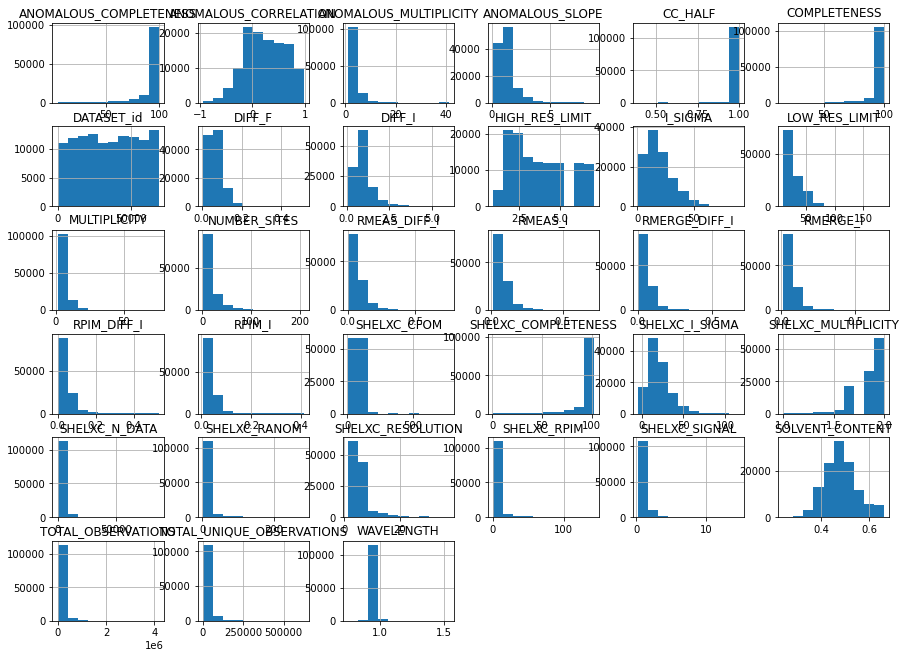

In [13]:
x.hist(figsize=(15, 11))
plt.show()

There are many features, so the layout might look constrained. The important observation is that most features appear to have **outliers**; some more significant than others, but they are there. For this reason, following the analysis we will also analyse the *median* of each feature, instead of just the *mean*, in order to reduce outlier influence.

Also, most features appear to be skewed, and don't seem to follow a normal distribution. **Solvent content** is the  exception, together with the understandly regular **dataset ids**.

## Correlation & Indicators

A correlation matrix was then used to identify initial correlation between features and label. **High resolution limit** seems to be the most correlated metric, followed by **DIFF F** and **SHELXC resolution/CFOM/multiplicity/I_SIGMA**. These mostly relate to how finely the structure factor/phasing can be resolved, and how precise this solving is.

**Total (unique) observations**, **SHELXC N data** also have high (and similar) correlations. This is to be expected, since they all relate to the signal intensity, or the quantity of data available. **Anomalous correlation** also has a high correlation.

On the other hand, the **completeness** variations have average correlation, while **multiplicity**, **number of sites**, **wavelength**, **solvent content**, **low resolution limit**, **anomalous slope**, and (unsurprisingly) **dataset id** have among the lowest correlations.

In [7]:
corr_sorted = abs(x.corrwith(y)).sort_values(ascending=False)
print(corr_sorted)

HIGH_RES_LIMIT               0.388109
SHELXC_RESOLUTION            0.219051
DIFF_F                       0.180352
SHELXC_CFOM                  0.173497
SHELXC_MULTIPLICITY          0.165726
SHELXC_I_SIGMA               0.165083
I_SIGMA                      0.154476
TOTAL_UNIQUE_OBSERVATIONS    0.143695
ANOMALOUS_CORRELATION        0.143211
RMERGE_I                     0.137550
SHELXC_N_DATA                0.130983
TOTAL_OBSERVATIONS           0.130078
RMEAS_I                      0.129897
RMERGE_DIFF_I                0.100591
RMEAS_DIFF_I                 0.099898
RPIM_I                       0.097748
SHELXC_COMPLETENESS          0.095788
ANOMALOUS_COMPLETENESS       0.093413
RPIM_DIFF_I                  0.093313
DIFF_I                       0.090879
COMPLETENESS                 0.086270
SHELXC_SIGNAL                0.052102
CC_HALF                      0.045610
SHELXC_RANOM                 0.045047
SHELXC_RPIM                  0.045039
NUMBER_SITES                 0.033344
WAVELENGTH  

A union dataset, including both the features and labels in a single dataframe was created for convenience. It was then grouped by success status, and the summary statistics observed.

In [8]:
union = pd.concat([x.iloc[:, 2:], y], axis=1)
print(union.groupby("IS_SUCCESS").describe())

           HIGH_RES_LIMIT                                                  \
                    count      mean       std   min  25%  50%   75%   max   
IS_SUCCESS                                                                  
0.0               95613.0  4.023419  1.720236  0.91  2.5  3.5  5.00  7.06   
1.0               23368.0  2.368002  0.556708  1.10  2.0  2.5  2.55  7.02   

           LOW_RES_LIMIT             ... SOLVENT_CONTENT         NUMBER_SITES  \
                   count       mean  ...             75%     max        count   
IS_SUCCESS                           ...                                        
0.0              95613.0  27.244501  ...          0.5197  0.6647      95613.0   
1.0              23368.0  26.404717  ...          0.5204  0.6645      23368.0   

                                                               
                 mean        std  min  25%   50%   75%    max  
IS_SUCCESS                                                     
0.0         17.4

For a more quantitative analysis, the relative difference of the success/failure *mean* & *median* values of each metric was obtained and sorted.

In [9]:
import pandas as pd
pd.set_option("display.max_rows", None)
grp_meds = union.groupby("IS_SUCCESS").agg(["mean", "median"])
rel_diff = abs(1 - grp_meds.iloc[1, :] / grp_meds.iloc[0, :])
rel_diff = rel_diff.sort_values(ascending=False)
print(rel_diff * 100)

TOTAL_OBSERVATIONS         median    299.118813
TOTAL_UNIQUE_OBSERVATIONS  median    280.779055
SHELXC_N_DATA              median    272.136752
ANOMALOUS_CORRELATION      median     92.737430
TOTAL_OBSERVATIONS         mean       68.026689
SHELXC_N_DATA              mean       65.916082
TOTAL_UNIQUE_OBSERVATIONS  mean       65.219465
ANOMALOUS_CORRELATION      mean       61.988903
RPIM_DIFF_I                median     45.161290
RMEAS_DIFF_I               median     42.592593
DIFF_F                     median     42.105263
RMERGE_DIFF_I              median     41.860465
RMERGE_I                   median     41.818182
HIGH_RES_LIMIT             mean       41.144533
SHELXC_RESOLUTION          mean       40.039161
                           median     40.000000
RMEAS_I                    median     38.095238
RPIM_I                     median     35.714286
HIGH_RES_LIMIT             median     28.571429
DIFF_F                     mean       27.951480
I_SIGMA                    median     27

From this table major differences can be noticed. **Total (unique) observations** and **SHELXC N data** show the most correlation difference between success or failure, in both *mean* and *median*. As before, they represent the intensity or number of data collected. It is to be expected that a stronger signal would allow for better EP.

Following this there's **anomalous correlation**, another strong indicator of success. Since the relative difference of each of the previous is above 60%, and up to 300%, these make up the ***4 most promising features*** (at least so far). The remaining features are more evenly distributed in the 40%-0% range.

However, other promising features are the **high resolution limit** and **SHELXC resolution**. These have average-high relative differences, and they represent how finely the structure can be mapped. Other metrics have similar differences, such as **RPIM/RMEAS/RMERGE (DIFF) I** and **DIFF F**. Representing how precise the recombination of scans/maps was. They represent similar things, so one would expect **DIFF F** and **DIFF I** to be similar, however the first is larger than the latter in both metrics.

All of these are strong indicative features, and should be taken into account in future predictive model building.

The low end of the table includes **multiplicity**, **completeness** (and shelx, anomalous variations), **low resolution limit**, **SHELX signal**, **solvent content**, **anomalous slope**, and smallest of all, **CC half**.

## Visualisation

**Visualisation** is an essential tool in understanding data. However, this dataset has a positive/negative label ratio of ~1/5, meaning that the **negative dominates**. Most color coded graphs are too clustered and dominated by the negative data to present any useful insight.

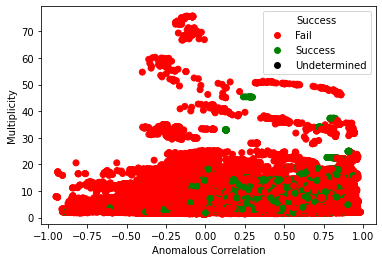

In [10]:
x_plot, y_plot = x["ANOMALOUS_CORRELATION"], x["MULTIPLICITY"]

fig, ax = plt.subplots()

cmap = {0: "red", 1: "green", np.nan: "black"}
ax.scatter(x_plot, y_plot, c=y.map(cmap))

ax.set_xlabel(x_plot.name.replace("_", " ").lower().title())
ax.set_ylabel(y_plot.name.replace("_", " ").lower().title())

# add a legend
handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=v, label=k, markersize=8)
           for k, v in {"Fail": "red", "Success": "green", "Undetermined": "black"}.items()]
ax.legend(title="Success", handles=handles)

plt.show()

To solve this, I've thought of **truncating the negative data**, making it so there's the same amount of negative points as there is positive. This would of course result in a loss of information, but it should also reduce bias, if done randomly that is.

In [11]:
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier

# reduce data to have same amount of positive/negative labels
n = np.count_nonzero(y)
lose = y == 0
lose_sample = y[lose].sample(n=n)
lose_sample_mask = lose_sample == 0
win = y == 1
win_sample = y[win].sample(n=n)
win_sample_mask = win_sample == 1

mask = y.astype(bool).copy()
mask.loc[:] = False
mask.update(lose_sample_mask)
mask.update(win_sample_mask)
x_redu, y_redu = x[mask], y[mask]

# plot again
x_plot, y_plot = x_redu["TOTAL_UNIQUE_OBSERVATIONS"], x_redu["HIGH_RES_LIMIT"]

'''kn = 20
X = pd.concat([x_plot, y_plot], axis=1)
clf = KNeighborsClassifier(kn)
clf.fit(X, y_redu)

# grid and predict
step = .1
x_min, x_max = X.iloc[:, 0].min() - .2, X.iloc[:, 0].max() + .2
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step=step),
                     np.arange(y_min, y_max, step=step))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)'''

fig, ax = plt.subplots()

cmap = {0: "red", 1: "green", np.nan: "black"}
ax.contourf(xx, yy, Z, cmap=ListedColormap(["red", "green"]), alpha=.5)
#ax.scatter(x_plot, y_plot, c=y_redu.map(cmap))

ax.set_xlabel(x_plot.name.replace("_", " ").lower().title())
ax.set_ylabel(y_plot.name.replace("_", " ").lower().title())

# add a legend
handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=v, label=k, markersize=8)
           for k, v in {"Fail": "red", "Success": "green", "Undetermined": "black"}.items()]
ax.legend(title="Success", handles=handles)

plt.show()

MemoryError: Unable to allocate 76.4 GiB for an array with shape (512790608, 20) and data type float64

## Use space group, solvent content & number of sites. Group by wavelength, resolution limits. Also try PCA.

https://github.com/erdogant/pca